In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from obspy.io.segy.segy import _read_segy
import matplotlib.ticker as ticker
from scipy.interpolate import griddata
import zipfile
from fastkml import kml
from shapely.geometry import Point
from matplotlib.ticker import MultipleLocator, FormatStrFormatter
from pyproj import Proj, Transformer

In [6]:
# Load in gravity locations
dfs = pd.read_excel('../data/GravPlot.xlsx', sheet_name=None)

# Load in individual sheets
df1 = dfs['Group 5']
df2 = dfs['Group 1']

In [22]:
# Load in refraction line locations
df_refract = pd.read_csv('../data/2025-05-19-NSS.csv')

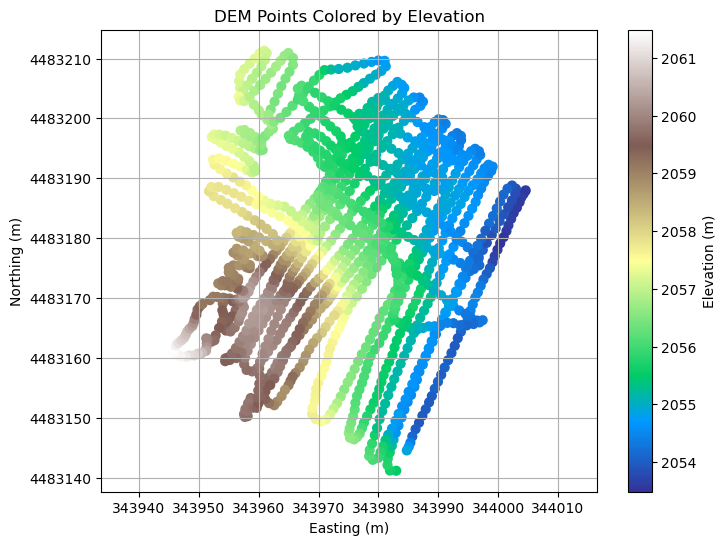

In [7]:
# Load in sulpher cave DEM
df_dem = pd.read_csv("../data/sulfur_cave_DEM_GPS_20220526.csv")

# Plot DEM points
plt.figure(figsize=(8, 6))
sc = plt.scatter(df_dem["Easting"], df_dem["Northing"], c=df_dem["Elevation"], cmap='terrain', s=40)
plt.colorbar(sc, label="Elevation (m)")

# Formatting
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.title("DEM Points Colored by Elevation")
plt.grid(True)
plt.axis('equal')

# Show full number ticks
ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))

plt.show()

In [10]:
# read 2024 GPS files (from Jack Dollars code GPS_plotting_2024)
def read_gp2(filename):
    eastings, northings = [], []
    with open(filename, 'r') as file:
        for line in file:
            parts = line.strip().split(',')  # Split by comma

            # Ensure there are enough columns before accessing indices
            if len(parts) >= 9:
                try:
                    easting = float(parts[8])  # 9th value (index 8)
                    northing = float(parts[6])  # 7th value (index 6)
                    eastings.append(easting)
                    northings.append(northing)
                except ValueError:
                    print(f"Skipping invalid line: {line.strip()}")  # Debugging info

    return eastings, northings

Skipping invalid line: 99,0,0.0,17.3239192963,"$GPGGA,,,,,,,,,,,,,,*56"
Skipping invalid line: 108,0,0.0,18.2310237885,"$GPGGA,,,,,,,,,,,,,,*56"
Skipping invalid line: 116,0,0.0,19.3546352386,"$GPGGA,,,,,,,,,,,,,,*56"


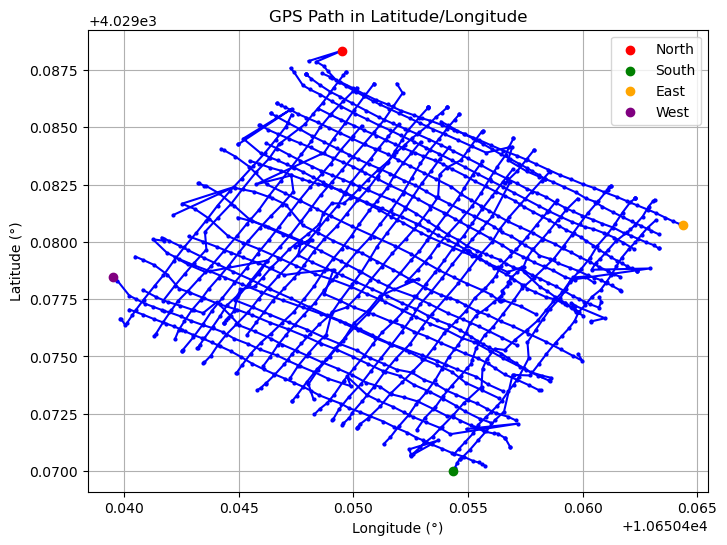

In [16]:
# Plot 2024 GPS files and get corner points

all_lons = []
all_lats = []

plt.figure(figsize=(8, 6))
plt.xlabel("Longitude (°)")
plt.ylabel("Latitude (°)")
plt.title("GPS Path in Latitude/Longitude")

# Collect all lat/lon points
for i in range(1, 50):
    lons, lats = read_gp2(f'../data/2024 GPR/Line{i}-ch2.gp2')  # assumed to return lon, lat
    all_lons.extend(lons)
    all_lats.extend(lats)
    plt.plot(lons, lats, marker='o', linestyle='-', color='blue', markersize=2)

# Convert to arrays
all_lons = np.array(all_lons)
all_lats = np.array(all_lats)

# Find extreme point indices
north_idx = np.argmax(all_lats)
south_idx = np.argmin(all_lats)
east_idx = np.argmax(all_lons)
west_idx = np.argmin(all_lons)

# Get their coordinates
north_point = (all_lons[north_idx], all_lats[north_idx])
south_point = (all_lons[south_idx], all_lats[south_idx])
east_point  = (all_lons[east_idx],  all_lats[east_idx])
west_point  = (all_lons[west_idx],  all_lats[west_idx])

# Plot the extreme points
plt.scatter(*north_point, color='red', label='North', zorder=5)
plt.scatter(*south_point, color='green', label='South', zorder=5)
plt.scatter(*east_point,  color='orange', label='East', zorder=5)
plt.scatter(*west_point,  color='purple', label='West', zorder=5)

plt.grid()
plt.legend()
plt.axis('equal')
plt.show()

In [17]:
# Function to convert ddm to decimal degrees

def ddm_to_dd(ddm):
    """
    Convert Degrees and Decimal Minutes (DDM) to Decimal Degrees (DD).
    Assumes input is a float like 4029.0883419 for 40°29.0883419′.
    """
    degrees = int(ddm / 100)
    minutes = ddm - (degrees * 100)
    return degrees + minutes / 60

# Your input points (Lon, Lat) in DDM
points_ddm = {
    "North Point": (10650.4494946, 4029.0883419),
    "East Point":  (10650.4643797, 4029.0807327),
    "South Point": (10650.4543668, 4029.0700157),
    "West Point":  (10650.4395152, 4029.0784725),
}

# Set up UTM Zone 13N (for Steamboat Springs, CO)
transformer = Transformer.from_crs("epsg:4326", "epsg:32613", always_xy=True)

# Convert and print results
for label, (lon_ddm, lat_ddm) in points_ddm.items():
    lon_dd = -ddm_to_dd(lon_ddm)  # West is negative
    lat_dd = ddm_to_dd(lat_ddm)   # North is positive
    easting, northing = transformer.transform(lon_dd, lat_dd)
    print(f"{label} (Easting, Northing): ({easting:.3f}, {northing:.3f})")


North Point (Easting, Northing): (343980.351, 4483195.702)
East Point (Easting, Northing): (343959.029, 4483182.063)
South Point (Easting, Northing): (343972.760, 4483161.940)
West Point (Easting, Northing): (343994.067, 4483177.148)


In [20]:
# Load in 2025 GPR data
df_GPR25 = pd.read_csv('../data/GPR_pts.csv')

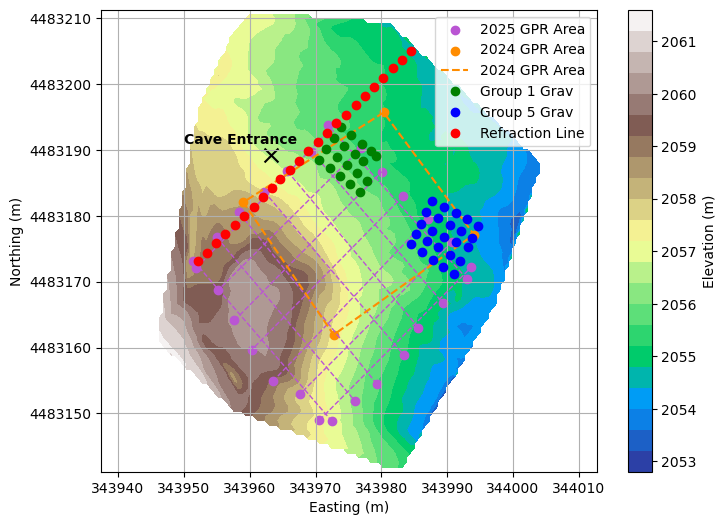

In [28]:
# Create a grid for interpolation
xi = np.linspace(df_dem["Easting"].min(), df_dem["Easting"].max(), 100)
yi = np.linspace(df_dem["Northing"].min(), df_dem["Northing"].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate elevation values onto the grid
zi = griddata(
    (df_dem["Easting"], df_dem["Northing"]),
    df_dem["Elevation"],
    (xi, yi),
    method='cubic'
)

# Plotting
plt.figure(figsize=(8, 6))

# Contour fill for elevation
contour = plt.contourf(xi, yi, zi, levels=20, cmap='terrain')
cbar = plt.colorbar(contour, label="Elevation (m)")

# Set ticks every 1 unit with integer formatting
cbar.locator = MultipleLocator(1)
cbar.formatter = FormatStrFormatter('%d')
cbar.update_ticks()

# Cave entrance
plt.scatter(343963.25, 4483189.21, marker="x", color="k", s=100)
plt.text(343950, 4483191, "Cave Entrance", fontsize=10, color="black", fontweight="bold")

# 2025 GPR
plt.scatter(df_GPR25["Start Easting"], df_GPR25["Start Northing"], marker='o', color='mediumorchid', label="2025 GPR Area")
plt.scatter(df_GPR25["End Easting"], df_GPR25["End Northing"], marker='o', color='mediumorchid')

for _, row in df_GPR25.iterrows():
    plt.plot(
        [row["Start Easting"], row["End Easting"]],
        [row["Start Northing"], row["End Northing"]],
        linestyle='--', color='mediumorchid', linewidth=1
    )

# 2024 GPR
utm_points = []

for label, (lon_ddm, lat_ddm) in points_ddm.items():
    lon_dd = -ddm_to_dd(lon_ddm)  # West is negative
    lat_dd = ddm_to_dd(lat_ddm)
    easting, northing = transformer.transform(lon_dd, lat_dd)
    utm_points.append((easting, northing))
    
# Plot corner points
    if label == "North Point":
        plt.scatter(easting, northing, marker='o', color='darkorange', label=f"2024 GPR Area")
    else:
        plt.scatter(easting, northing, marker='o', color='darkorange')
# Close loop
utm_points.append(utm_points[0])  # Close the loop

# Separate x and y for plotting
x, y = zip(*utm_points)

# Connect points with dashed black line
plt.plot(x, y, linestyle='--', color='darkorange', linewidth=1.5, label="2024 GPR Area")
    
# Gravity
plt.plot(df2["Easting (m)"], df2["Northing (m)"], 'o', label="Group 1 Grav", color='green')
plt.plot(df1["Easting (m)"], df1["Northing (m)"], 'o', label="Group 5 Grav", color='blue')
plt.plot(df_refract["Easting"], df_refract["Northing"], 'o', label="Refraction Line", color='red')
    
# Labels and formatting
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True)
plt.axis('equal')

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
plt.legend()

plt.savefig("survey_pts_2")
plt.show()

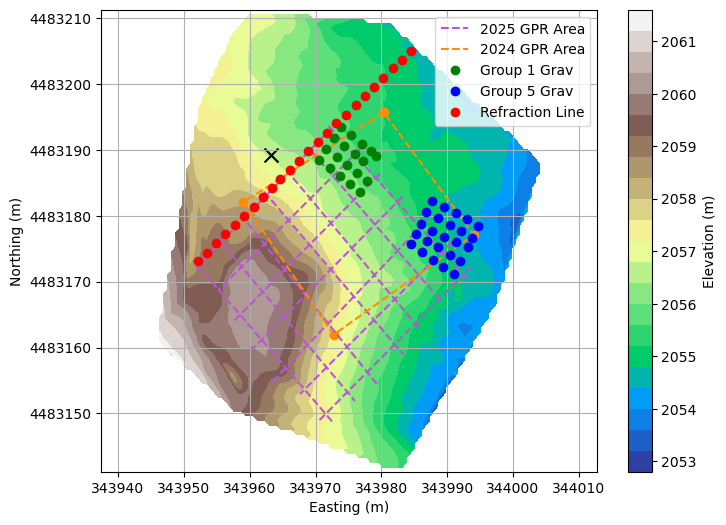

In [39]:
# Create a grid for interpolation
xi = np.linspace(df_dem["Easting"].min(), df_dem["Easting"].max(), 100)
yi = np.linspace(df_dem["Northing"].min(), df_dem["Northing"].max(), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate elevation values onto the grid
zi = griddata(
    (df_dem["Easting"], df_dem["Northing"]),
    df_dem["Elevation"],
    (xi, yi),
    method='cubic'
)

# Plotting
plt.figure(figsize=(8, 6))

# Contour fill for elevation
contour = plt.contourf(xi, yi, zi, levels=20, cmap='terrain')
cbar = plt.colorbar(contour, label="Elevation (m)")

# Set ticks every 1 unit with integer formatting
cbar.locator = MultipleLocator(1)
cbar.formatter = FormatStrFormatter('%d')
cbar.update_ticks()

# Cave entrance
plt.scatter(343963.25, 4483189.21, marker="x", color="k", s=100)

# 2025 GPR
# plt.scatter(df_GPR25["Start Easting"], df_GPR25["Start Northing"], marker='o', color='mediumorchid', label="2025 GPR Area")
# plt.scatter(df_GPR25["End Easting"], df_GPR25["End Northing"], marker='o', color='mediumorchid')

for i, (_, row) in enumerate(df_GPR25.iterrows()):
    plt.plot(
        [row["Start Easting"], row["End Easting"]],
        [row["Start Northing"], row["End Northing"]],
        linestyle='--', color='mediumorchid',
        label="2025 GPR Area" if i == 0 else None  # Add label only once
    )

# 2024 GPR
utm_points = []

for label, (lon_ddm, lat_ddm) in points_ddm.items():
    lon_dd = -ddm_to_dd(lon_ddm)  # West is negative
    lat_dd = ddm_to_dd(lat_ddm)
    easting, northing = transformer.transform(lon_dd, lat_dd)
    utm_points.append((easting, northing))
    
#Plot corner points
    if label == "North Point":
        plt.scatter(easting, northing, marker='o', color='darkorange')
    else:
        plt.scatter(easting, northing, marker='o', color='darkorange')
# Close loop
utm_points.append(utm_points[0])  # Close the loop

# Separate x and y for plotting
x, y = zip(*utm_points)

# Connect points with dashed black line
plt.plot(x, y, linestyle='--', color='darkorange', linewidth=1.5, label="2024 GPR Area")
    
# Gravity
plt.plot(df2["Easting (m)"], df2["Northing (m)"], 'o', label="Group 1 Grav", color='green')
plt.plot(df1["Easting (m)"], df1["Northing (m)"], 'o', label="Group 5 Grav", color='blue')
plt.plot(df_refract["Easting"], df_refract["Northing"], 'o', label="Refraction Line", color='red')
    
# Labels and formatting
plt.xlabel("Easting (m)")
plt.ylabel("Northing (m)")
plt.grid(True)
plt.axis('equal')

ax = plt.gca()
ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: f"{x:.0f}"))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda y, _: f"{y:.0f}"))
plt.legend()

plt.savefig("survey_pts_2")
plt.show()